In [1]:
# IMPORT
from IPython.display import Image, Math

import os
import numpy as np
import pandas as pd
from utils import *
import pyAgrum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as pyc
import pyAgrum.causal.notebook as cslnb
# from pyAgrum.lib.discretizer import Discretizer
import re
from sklearn.cluster import KMeans
# from kneed import KneeLocator
from scipy.stats import iqr, gaussian_kde, entropy
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'  # Set background to white globally
plt.rcParams['axes.facecolor'] = 'white'    # Set axis background to white
import warnings
import pickle
warnings.filterwarnings("ignore")

print(pyAgrum.__version__)

1.13.2


In [2]:
def format_evidence_for_latex(evidence):
    formatted_evidence = []
    
    for var in evidence.keys():
        # Replace the part after the underscore with curly braces, if applicable
        var = re.sub(r'_(\w+)', r'_{\1}', var)  # Add {} around the part after the underscore
        
        # Replace '0' with '_{t-1}'
        var = var.replace('t', '_t')
        var = var.replace('0', '_{t-1}')

        # Append formatted variable to the list
        formatted_evidence.append(f"${var}$")  # Adding $ for LaTeX format
        
    return ', '.join(formatted_evidence)

def plot_distributions(var, distributions, var_midpoints, xlabel, ylabel):
    # Number of distributions to plot
    n = len(distributions)
    
    # Create subplots (one for each distribution)
    fig, axes = plt.subplots(1, n, figsize=(12, 4))

    # If there's only one plot, axes is not a list, so we handle it separately
    if n == 1:
        axes = [axes]
    var_midpoints = [round(float(m),2) for m in var_midpoints]
    for i, (data, title) in enumerate(distributions):
        # Plot the distribution in the corresponding subplot
        axes[i].bar(range(len(data)), data)
        axes[i].set_xticks(range(len(data)), var_midpoints)
        var_str = format_evidence_for_latex({var: None})
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()
    
def find_bin(value, edges):
    """
    Given a continuous value and an array of bin edges,
    return the index of the bin that contains the value.
    """
    idx = np.digitize(value, edges, right=False) - 1
    return int(max(0, min(idx, len(edges) - 2)))

def get_info(D, auditDict, var):
    if auditDict[var]['method'] == 'NoDiscretization':
        edges = auditDict[var]['values']
        midpoints = auditDict[var]['values']
        return 'NoDiscretization', edges, midpoints
    elif 'param' in auditDict[var] and isinstance(auditDict[var]['param'], list):
        edges = auditDict[var]['param']
        midpoints = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
        return auditDict[var]['param'], edges, midpoints
    quantiles = np.linspace(0, 100, auditDict[var]['param'] + 1 if 'param' in auditDict[var] else auditDict[var]['nbBins'] + 1)
    edges = np.percentile(D[var].values, quantiles)
    midpoints = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
    return quantiles, edges, midpoints

In [3]:
import copy
from causalflow.preprocessing.data import Data


def load_D(indir, bagname):
    dfs = []
    for i, wp in enumerate(WP):
        if wp == WP.PARKING or wp == WP.CHARGING_STATION: continue
        for tod in TOD:
            files = [f for f in os.listdir(os.path.join(indir, "HH/my_nonoise", f"{bagname}", f"{tod.value}"))]
            files_split = [f.split('_') for f in files]
            wp_files = [f for f in files_split if len(f) == 3 and f[2].split('.')[0] == wp.value][0]
            wp_file = '_'.join(wp_files)
            # print(f"Loading : {wp_file}")
            filename = os.path.join(indir, "HH/my_nonoise", f"{bagname}", f"{tod.value}", wp_file)

            df = pd.read_csv(filename)
            df = df.drop(['pf_elapsed_time', 'T', 'R_X', 'R_Y', 'G_X', 'G_Y', 'NP', 'R_B'], axis=1)
            pd_mean = np.mean(df['PD'].values)
            df['PD'] = np.full_like(df['PD'].values, pd_mean)
            dfs.append(df)
        # if i == 4: break
    D = pd.concat(dfs, ignore_index=True)
    D = D[(D['R_V'] <= 0.6)]
    
    D.rename(columns={'R_V': 'RV', 'C_S': 'CS'}, inplace=True)
    d = copy.copy(D)
    original_names = list(D.columns)
    D.columns = [f'{v}t' for v in original_names]

    # Add lagged variable
    for v in original_names:
        D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
    D = D.iloc[1:].reset_index(drop=True)  # Remove first row
    D = D.iloc[:-1].reset_index(drop=True)  # Remove last row
    
    return d, D


def load_specific_D(indir, wp, tod):
    dfs = []
    print(f"Loading : {indir}/{tod}")
    dfs.append(pd.read_csv(f"{indir}/{tod}.csv"))
    
    df = pd.concat(dfs)
    
    
    D = df[['TOD', f'{wp}_PD']].copy()
    D.rename(columns={f'{wp}_PD': 'PD'}, inplace=True)
    D['WP'] = WPS[wp]
    D.dropna(inplace=True)  # Drop rows with NaNs before lagging

    d = copy.copy(D)
    original_names = list(D.columns)
    D.columns = [f'{v}t' for v in original_names]

    # Add lagged variable
    for v in original_names:
        D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
    
    D = D.iloc[1:].reset_index(drop=True)  # Remove first row
    D = D.iloc[:-1].reset_index(drop=True)  # Remove last row
    
    return d, D


def load_specific_WP(indir, wp):
    dfs = []
    for tod in TOD:
        print(f"Loading : {indir}/{tod.value}")
        dfs.append(pd.read_csv(f"{indir}/{tod.value}.csv"))
    
    df = pd.concat(dfs)
    
    
    D = df[['TOD', f'{wp}_PD']].copy()
    D.rename(columns={f'{wp}_PD': 'PD'}, inplace=True)
    D['WP'] = WPS[wp]
    D.dropna(inplace=True)  # Drop rows with NaNs before lagging

    d = copy.copy(D)
    original_names = list(D.columns)
    D.columns = [f'{v}t' for v in original_names]

    # Add lagged variable
    for v in original_names:
        D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
    
    D = D.iloc[1:].reset_index(drop=True)  # Remove first row
    D = D.iloc[:-1].reset_index(drop=True)  # Remove last row
    
    return d, D

In [4]:
INDIR = '/home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv'
OUTDIR = "CIE" 
os.makedirs(OUTDIR, exist_ok=True)

dfs = {}
for wp in WP:
    df, D = load_specific_WP(INDIR, wp.value)
    dfs[wp.value] = D
    
# Save `dfs` to a pickle file
with open(f"{OUTDIR}/Ds.pkl", "wb") as f:
    pickle.dump(dfs, f)

Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/sr

In [5]:
# DISCRETIZATION -- 

AUDITs = {}

for wp in WP:
    discretizer=skbn.BNDiscretizer(defaultDiscretizationMethod='quantile')

    # Define structure
    template = discretizer.discretizedBN(dfs[wp.value])
    auditDict = discretizer.audit(dfs[wp.value])
    template.addArc("WP0", "PD0")
    template.addArc("TOD0", "PD0")
    template.addArc("WPt", "PDt")
    template.addArc("TODt", "PDt")
    template.addArc("PD0", "PDt")

    # Learn parameters for each dataset
    learner = pyAgrum.BNLearner(dfs[wp.value], template)
    learner.useSmoothingPrior()
    bn = learner.learnParameters(template)
    AUDITs[wp.value] = auditDict
    
    pyAgrum.saveBN(bn, f"{OUTDIR}/CIE_{wp.value}.bifxml")
    
with open(f"{OUTDIR}/AUDITs.pkl", "wb") as f:
    pickle.dump(AUDITs, f)

In [6]:
target_var = 'PD0'
target_var_str = format_evidence_for_latex({target_var: None})
intervention_var = "TOD0"
STEP = 5
time = 5

plot_fontsize = 20

Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/sr

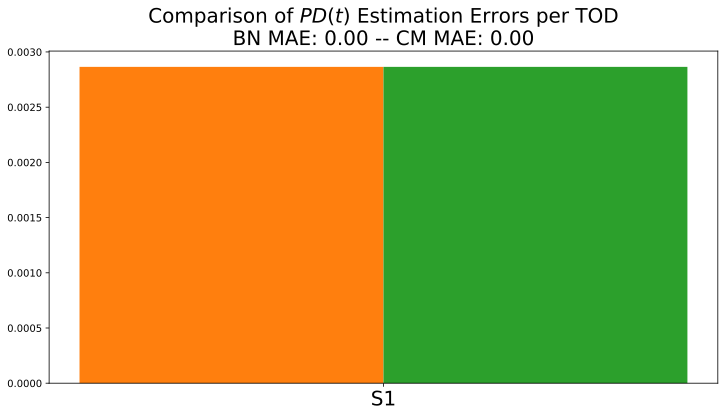

In [8]:
figs_pd = f'{OUTDIR}/figs_pd'
os.makedirs(figs_pd, exist_ok=True)

bn_err = []
cm_err = []

AUDITs = pickle.load(open(f"{OUTDIR}/AUDITs.pkl", "rb"))

for wp in WP:
    gts = []
    bayes_preds = []
    causal_preds = []
    wp_bin = 0
    
    bn = pyAgrum.loadBN(f"{OUTDIR}/CIE_{wp.value}.bifxml")
    cm = pyc.CausalModel(bn)
    dwp = pickle.load(open(f"{OUTDIR}/Ds.pkl", "rb"))[wp.value]
    _, _, midpoints_PD = get_info(dwp, AUDITs[wp.value], target_var)

    for idx_tod, tod in enumerate(TOD):
        df, D_tod = load_specific_D(INDIR, wp.value, tod.value)
        PD = np.mean(D_tod[target_var].values)
        gts.append(PD)
        
        # --- BN prediction ---
        ie = pyAgrum.VariableElimination(bn)
        bn_prior = ie.posterior(target_var)
        evidence = {intervention_var: idx_tod, "WP0": wp_bin}
        evidence_str = format_evidence_for_latex(evidence)
        ie.setEvidence(evidence)
        ie.makeInference()
        bn_posterior = ie.posterior(target_var)
        bn_posterior_values = bn_posterior.toarray()
        pred_bn = float(np.dot(bn_posterior_values, midpoints_PD))
        bayes_pred = (time/STEP)*pred_bn
                        
        # --- CausalModel prediction ---
        formula, adj, exp = pyc.causalImpact(cm, on=target_var, doing=intervention_var, knowing={"WP0"}, values=evidence)
        posterior_causal = adj.toarray()
        pred_causal = float(np.dot(posterior_causal, midpoints_PD))
        causal_pred = (time/STEP)*pred_causal
                        
        bayes_preds.append(bayes_pred)
        causal_preds.append(bayes_pred)
        
    bn_errors = np.abs(np.array(bayes_preds)-np.array(gts))
    cm_errors = np.abs(np.array(causal_preds)-np.array(gts))
    
    bn_err.append(bn_errors)
    cm_err.append(cm_errors)

    # Define bar width and offsets
    bar_width = 0.25
    x_indexes = np.arange(len(TOD))

    # Plot bars for each category with offset
    plt.figure(figsize=(12, 6))
    plt.bar(x_indexes - bar_width, gts, width=bar_width, label="Ground Truth", color='tab:blue', alpha=1)
    plt.bar(x_indexes, bayes_preds, width=bar_width, label=r"BN: E[$\Delta R_B$|$R_V$,$C_S$]", color='tab:orange', alpha=1)
    plt.bar(x_indexes + bar_width, causal_preds, width=bar_width, label=r"CM: E[$\Delta R_B$|do($R_V$),$C_S$]", color='tab:green', alpha=1)
    plt.xticks(x_indexes, [f"{tod.value}" for tod in TOD], fontsize=plot_fontsize)  # Format x-axis labels
    plt.savefig(f"{figs_pd}/{wp.value}.png")
    plt.close()
    
    plt.figure(figsize=(12, 6))
    plt.bar(x_indexes - bar_width/2, bn_errors, width=bar_width, label=r"BN: E[$\Delta R_B$|$R_V$,$C_S$]", color='tab:orange', alpha=1)
    plt.bar(x_indexes + bar_width/2, cm_errors, width=bar_width, label=r"CM: E[$\Delta R_B$|do($R_V$),$C_S$]", color='tab:green', alpha=1)
    plt.xticks(x_indexes, [f"{tod.value}" for tod in TOD], fontsize=plot_fontsize)  # Format x-axis labels
    plt.title(r"Comparison of $PD(t)$ " + f"Estimation Errors BN MAE: {np.mean(bn_errors, axis=0):.2f} -- CM MAE: {np.mean(cm_errors, axis=0):.2f}", fontdict={'fontsize': plot_fontsize})
    plt.savefig(f"{figs_pd}/{wp.value}_err.png")
    plt.close()
    
plt.figure(figsize=(12, 6))
plt.bar(x_indexes - bar_width/2, np.mean(bn_err, axis=0), width=bar_width, label=r"BN: E[$PD$|$TS$,$WP$]", color='tab:orange', alpha=1)
plt.bar(x_indexes + bar_width/2, np.mean(cm_err, axis=0), width=bar_width, label=r"CM: E[$PD$|do($TS$),$WP$]", color='tab:green', alpha=1)
plt.xticks(x_indexes, [f"{tod.value}" for tod in TOD], fontsize=plot_fontsize)  # Format x-axis labels
plt.title(r"Comparison of $PD(t)$ " + f"Estimation Errors per TOD\nBN MAE: {np.mean(np.mean(bn_err, axis=0), axis=0):.2f} -- CM MAE: {np.mean(np.mean(cm_err, axis=0), axis=0):.2f}", fontdict={'fontsize': plot_fontsize})
plt.show()